In [2]:
%%capture
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf
import librosa
import librosa.display
import time
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestClassifier as RandomForest, HistGradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from keras.models import Sequential
from keras.layers import Bidirectional, Reshape, Lambda, Activation, Dense, LSTM, Dropout, Flatten, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping
from tensorflow.keras.losses import SparseCategoricalCrossentropy, MeanAbsoluteError, MeanSquaredError
from tensorflow.keras.optimizers import Adam
from PIL import Image
from glob import glob
from tabulate import tabulate
from pprint import pprint
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import pickle
from keras.callbacks import Callback

AUTOTUNE = tf.data.AUTOTUNE

AUDIO_MEL_SPECTROGRAM_IMAGES_DIR = './data/mel_spectrogram_images/'

OneHotEncodingConfig = {'0': [1, 0, 0, 0], '1': [0, 1, 0, 0], '2': [0, 0, 1, 0], '3': [0, 0, 0, 1]}
plt.rcParams['figure.dpi'] = 300

sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

In [3]:
def get_metrics(y_labels, y_pred, train_times, prediction_times, draw_corr_matrix=True):
    folds_size = 1107
    accs = []
    i = 0
    for f_i in range(5):
      acc = round(metrics.accuracy_score(
          y_labels[i:i+folds_size], y_pred[i:i+folds_size]) * 100, 2)
      print(f"Accuracy for fold {f_i}: {acc}%")
      accs.append(acc)

      i += folds_size

      if f_i == 0:
        folds_size = 1106

    table = [
        ["Accuracy",
            f"{round(metrics.accuracy_score(y_labels, y_pred) * 100, 2)}+-{round(np.std(accs), 2)}"],
        ["F1 score macro", round(metrics.f1_score(
            y_labels, y_pred, average='macro') * 100, 2)],
        ["Precision", round(metrics.precision_score(
            y_labels, y_pred, average='macro') * 100, 2)],
        ["Recall", round(metrics.recall_score(
            y_labels, y_pred, average='macro') * 100, 2)],
        ["Matthews corrcoef", round(
            metrics.matthews_corrcoef(y_labels, y_pred), 3)],
        ["Training Time", f"{round(np.sum(train_times), 2)}+-{round(np.std(train_times), 2)}"],
        ["Prediction Time", f"{round(np.sum(prediction_times), 2)}+-{round(np.std(prediction_times), 2)}"],
    ]
    print()
    print(tabulate(table, headers=["Metric", "Value"]))
    print()
    print(metrics.classification_report(y_labels, y_pred))

    if draw_corr_matrix:
        ticks = ['0 - angry', '1 - happy', '2 - neutral', '3 - sad']
        cm = metrics.confusion_matrix(y_labels, y_pred)
        plt.figure(figsize=(6, 6))
        sns.heatmap(cm, annot=True, fmt="d",
                    xticklabels=ticks, yticklabels=ticks)
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted Emotion Label")
        plt.ylabel("Real Emotion Label")
        plt.yticks(rotation=0)
        plt.show()


In [4]:
class ADJUSTLR(Callback):
    def __init__ (self, model, verbose):
        self.model = model
        self.freq = 5
        self.factor = .9
        self.verbose = verbose
        self.adj_epoch = 5
    def on_epoch_end(self, epoch, logs=None):
        if epoch + 1 == self.adj_epoch: # adjust the learning rate
            lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
            new_lr=lr * self.factor
            self.adj_epoch +=self.freq
            if self.verbose == 1:
                print('\non epoch ',epoch + 1, ' lr was adjusted from ', lr, ' to ', new_lr)
            tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer


def categorical_cross_validation(get_new_model, data_df, callback, no_epochs, batch_size, verbosity, num_folds):
  kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=1)

  all_y_pred = []
  all_y_labels = []

  training_times = []
  prediction_times = []

  X = data_df.iloc[:]
  y = data_df.iloc[:, 1]

  fold_no = 1
  for train, test in kfold.split(X, y):
    model = get_new_model()

    train_ds = X.iloc[train]
    train_ds = preprocess_dataset(train_ds.iloc[:, 0].values)
    train_ds = train_ds.batch(batch_size)
    train_ds = train_ds.cache().prefetch(AUTOTUNE)
    
    test_ds = X.iloc[test]
    test_ds = preprocess_dataset(test_ds.iloc[:, 0].values)
    test_ds = test_ds.batch(batch_size)
    test_ds = test_ds.cache().prefetch(AUTOTUNE)

    print(f'Training for fold {fold_no} ...')
    callback = ADJUSTLR(model, verbosity)

    start_time = time.time()
    model.fit(train_ds,
              validation_data=test_ds,
              batch_size=batch_size,
              epochs=no_epochs,
              verbose=verbosity,
              callbacks=[callback],
              workers=-1)
    training_times.append(time.time() - start_time)

    start_time = time.time()
    for spec, label in test_ds.take(len(test_ds)):
      y_pred = model.predict(spec.numpy())
      y_pred = [list(x).index(max(x)) for x in y_pred]
      all_y_pred.extend(y_pred)
      y_label = [x[0] for x in label.numpy()]
      all_y_labels.extend(y_label)
    prediction_times.append(time.time() - start_time)

    fold_no = fold_no + 1

  return all_y_labels, all_y_pred, training_times, prediction_times

# SOA Model 1 - https://doi.org/10.3390/s20010183

In [5]:
def build_model_1(input_shape, loss, optimizer):
    model = Sequential()
    model.add(Conv2D(16, (7, 7), strides=(2, 2), padding='same', activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (5, 5), strides=(2, 2), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), strides=(2, 2), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.75))
    model.add(Dense(4, activation='softmax'))
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    return model

# SOA Model 2 - https://www.isca-speech.org/archive/pdfs/interspeech_2018/ma18b_interspeech.pdf

In [6]:
from keras.layers import Reshape, Lambda, Bidirectional, LSTM

def ReshapeLayer(x):
    shape = x.shape
    reshape = Reshape((shape[1],shape[2]*shape[3]))(x)
    return reshape

def build_model_2(input_shape, loss, optimizer):
    model = Sequential()
    model.add(Conv2D(6, (1, 12), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((1, 2)))
    model.add(Conv2D(10, (1, 8), activation='relu'))
    model.add(MaxPooling2D((1, 2)))
    model.add(Lambda(ReshapeLayer))
    model.add(Bidirectional(LSTM(128)))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.64))
    model.add(Dense(4, activation='softmax'))
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    return model

In [7]:
def get_y_and_label(audio_file):
    audio_file = str(bytes.decode(audio_file.numpy()))
    with open(audio_file, 'rb') as f:
        spec = pickle.load(f)
    emotion = audio_file.split("-")[1][0]
    return spec, int(emotion)

def data_loader(filename):
    features, labels = tf.py_function(
        get_y_and_label, [filename], [tf.float32, tf.int64])
    return tf.reshape(features, [256, 188, 1]), tf.reshape(labels, [1])

def preprocess_dataset(files):
    filenames_ds = tf.data.Dataset.list_files(files)
    return filenames_ds.map(data_loader, num_parallel_calls=AUTOTUNE)

# Mel Spectrograms

In [11]:
%cd ../data/mel_spectrograms
data_df = pd.DataFrame([(file, file[-5]) for file in glob("*.pickle")])

def data_loader(filename):
    features, labels = tf.py_function(
        get_y_and_label, [filename], [tf.float32, tf.int64])
    return tf.reshape(features, [256, 188, 1]), tf.reshape(labels, [1])

print(len(data_df))
data_df.head()

c:\Users\Chico\Desktop\VADER\Audio_Sentiment_Analysis\iemocap\data\mel_spectrograms
5531


,0,1
0,Ses01F_impro01_F000-3-mel.pickle,i
1,Ses01F_impro01_F001-3-mel.pickle,i
2,Ses01F_impro01_F002-3-mel.pickle,i
3,Ses01F_impro01_F005-3-mel.pickle,i
4,Ses01F_impro01_F012-0-mel.pickle,i


## SOA Model 1

In [9]:
def get_new_model(input_shape=(256, 188, 1)):
    loss = SparseCategoricalCrossentropy()
    learning_rate = 1e-3
    optimizer = Adam(learning_rate=learning_rate)
    return build_model_1(input_shape, loss, optimizer)

get_new_model().summary(show_trainable=True)

Model: "sequential"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 conv2d (Conv2D)             (None, 128, 94, 16)       800       Y          
                                                                            
 batch_normalization (BatchN  (None, 128, 94, 16)      64        Y          
 ormalization)                                                              
                                                                            
 conv2d_1 (Conv2D)           (None, 64, 47, 32)        12832     Y          
                                                                            
 batch_normalization_1 (Batc  (None, 64, 47, 32)       128       Y          
 hNormalization)                                                            
                                                                            
 conv2d_2 (Conv2D)           (None, 32, 24, 32)        9

In [12]:
callback = EarlyStopping(monitor='loss', patience=5)
no_epochs = 60
batch_size = 128

verbosity = 1
num_folds = 5

all_y_labels, all_y_pred, training_times, prediction_times = categorical_cross_validation(
    get_new_model, data_df, callback, no_epochs, batch_size, verbosity, num_folds)

Training for fold 1 ...
Epoch 1/60
35/35 [==============================] - 25s 652ms/step - loss: 1.6825 - accuracy: 0.3318 - val_loss: 1.3337 - val_accuracy: 0.3379
Epoch 2/60
35/35 [==============================] - 20s 578ms/step - loss: 1.4082 - accuracy: 0.3623 - val_loss: 1.3228 - val_accuracy: 0.3369
Epoch 3/60
35/35 [==============================] - 19s 531ms/step - loss: 1.2998 - accuracy: 0.3736 - val_loss: 1.3101 - val_accuracy: 0.3406
Epoch 4/60
35/35 [==============================] - 19s 530ms/step - loss: 1.2607 - accuracy: 0.3953 - val_loss: 1.3060 - val_accuracy: 0.3451
Epoch 5/60
35/35 [==============================] - ETA: 0s - loss: 1.2359 - accuracy: 0.4005
on epoch  5  lr was adjusted from  0.0010000000474974513  to  0.0009000000427477062
35/35 [==============================] - 20s 557ms/step - loss: 1.2359 - accuracy: 0.4005 - val_loss: 1.3024 - val_accuracy: 0.3397
Epoch 6/60
35/35 [==============================] - 18s 513ms/step - loss: 1.2074 - accuracy: 

Accuracy for fold 0: 31.17%
Accuracy for fold 1: 20.71%
Accuracy for fold 2: 32.82%
Accuracy for fold 3: 30.29%
Accuracy for fold 4: 32.37%

Metric             Value
-----------------  -------------
Accuracy           29.47+-4.47
F1 score macro     18.81
Precision          23.89
Recall             27.78
Matthews corrcoef  0.042
Training Time      5851.75+-69.0
Prediction Time    8.88+-0.05

              precision    recall  f1-score   support

           0       0.29      0.35      0.32      1103
           1       0.30      0.75      0.42      1636
           2       0.00      0.00      0.00      1084
           3       0.37      0.00      0.01      1708

    accuracy                           0.29      5531
   macro avg       0.24      0.28      0.19      5531
weighted avg       0.26      0.29      0.19      5531



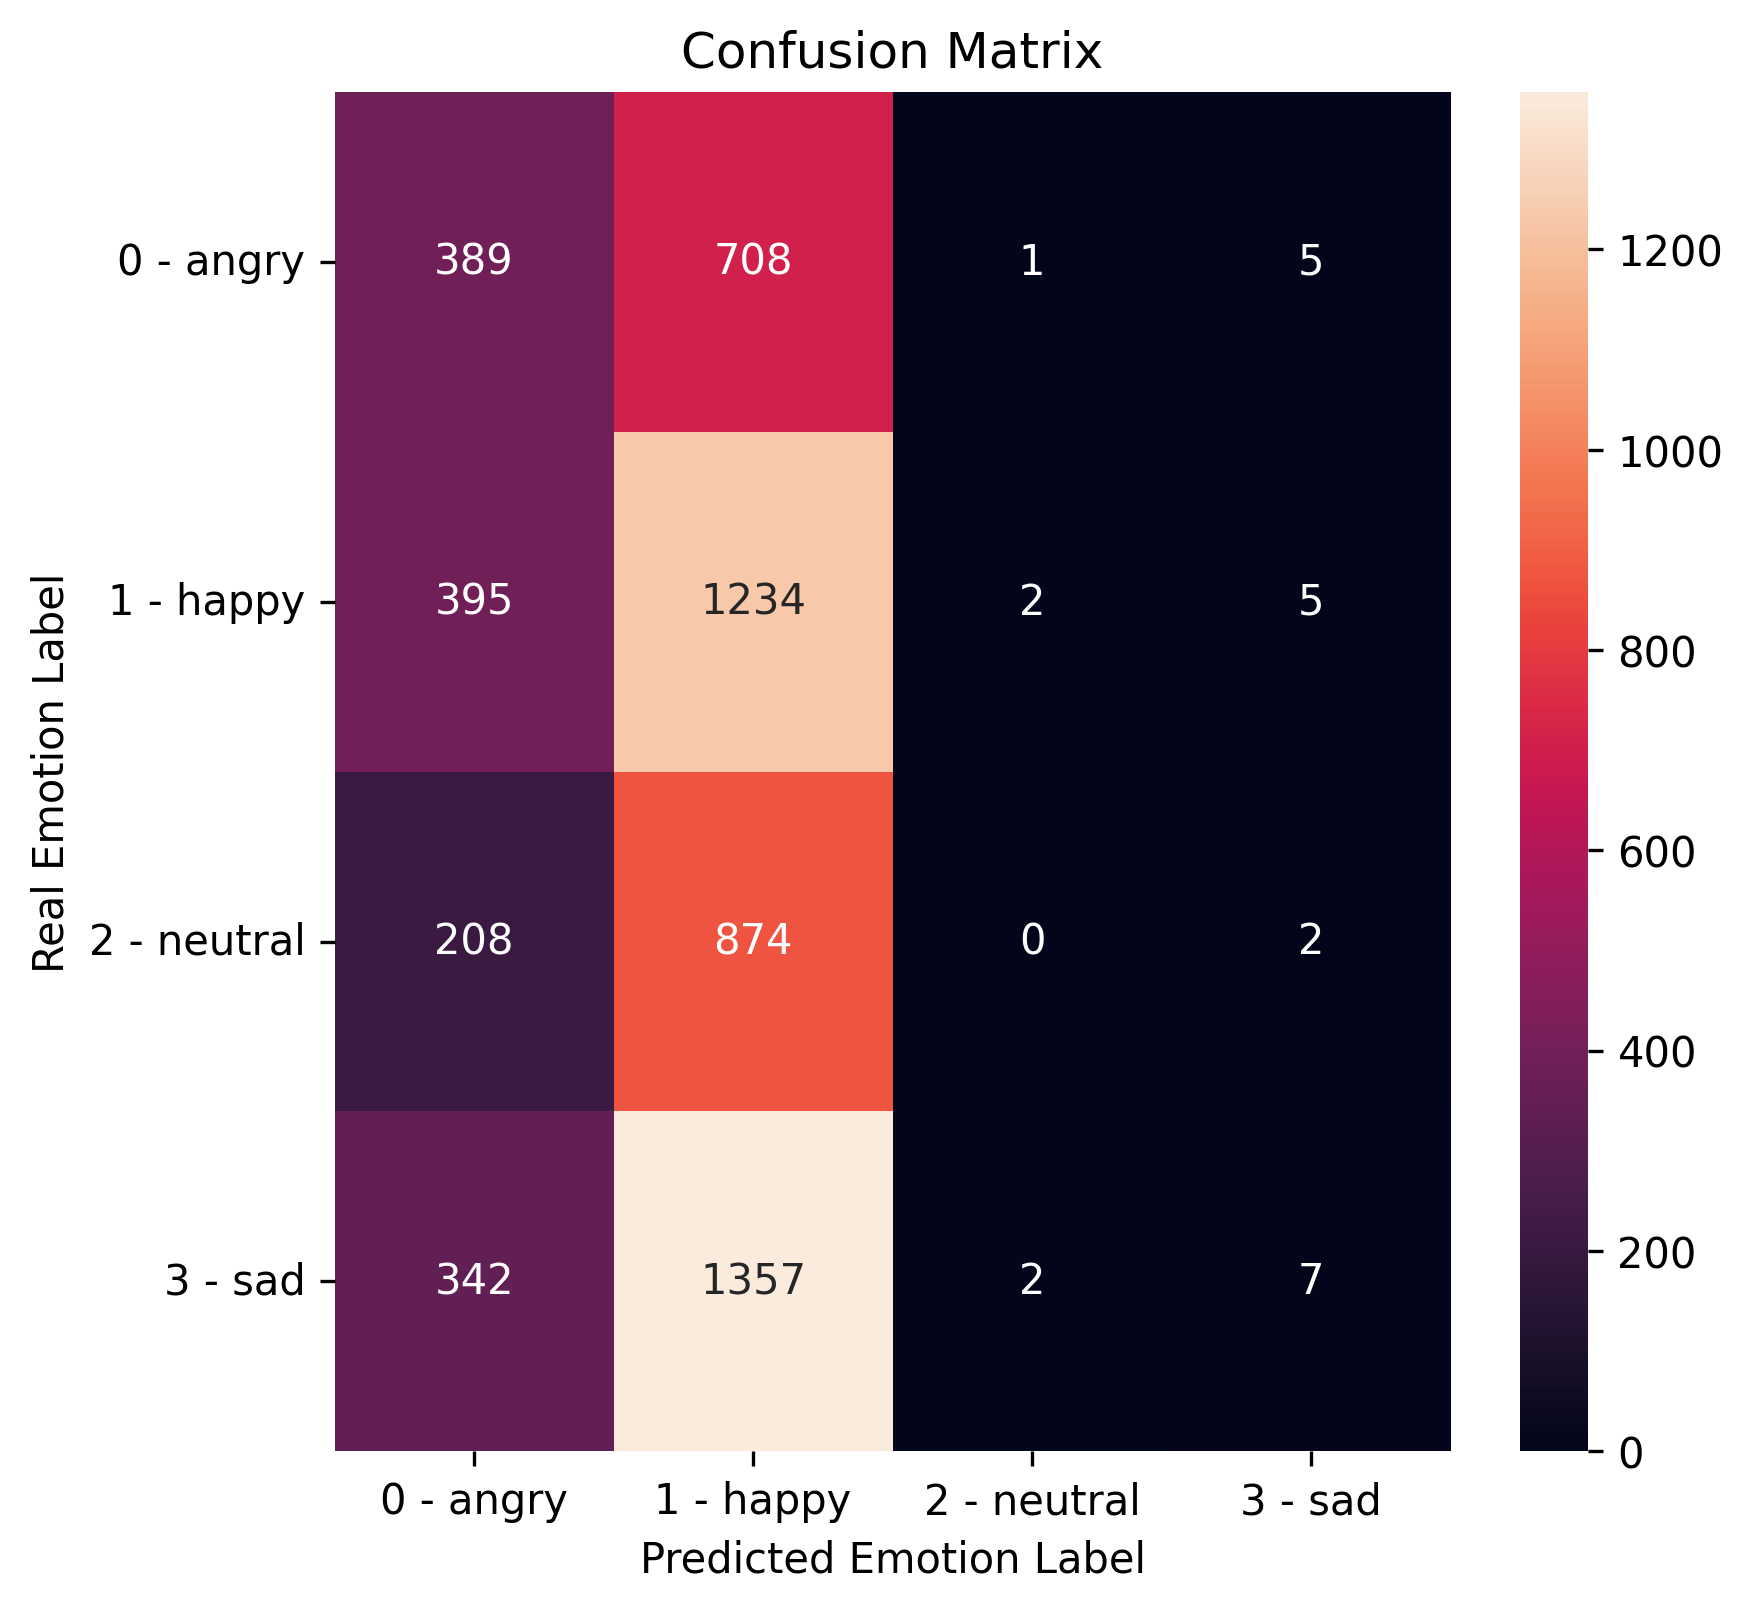

In [13]:
get_metrics(all_y_labels, all_y_pred, training_times, prediction_times)

## SOA Model 2

In [ ]:
def get_new_model(input_shape=(256, 188, 1)):
    loss = SparseCategoricalCrossentropy()
    learning_rate = 1e-3
    optimizer = Adam(learning_rate=learning_rate)
    return build_model_2(input_shape, loss, optimizer)

get_new_model().summary(show_trainable=True)

Model: "sequential_13"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 conv2d_85 (Conv2D)          (None, 256, 177, 6)       78        Y          
                                                                            
 batch_normalization_85 (Bat  (None, 256, 177, 6)      24        Y          
 chNormalization)                                                           
                                                                            
 max_pooling2d (MaxPooling2D  (None, 256, 88, 6)       0         Y          
 )                                                                          
                                                                            
 conv2d_86 (Conv2D)          (None, 256, 81, 10)       490       Y          
                                                                            
 max_pooling2d_1 (MaxPooling  (None, 256, 40, 10)    

In [ ]:
callback = EarlyStopping(monitor='loss', patience=5)
no_epochs = 60
batch_size = 128

verbosity = 1
num_folds = 5

all_y_labels, all_y_pred, training_times, prediction_times = categorical_cross_validation(
    get_new_model, data_df, callback, no_epochs, batch_size, verbosity, num_folds)

Training for fold 1 ...
Epoch 1/60
35/35 [==============================] - 27s 546ms/step - loss: 1.3033 - accuracy: 0.3490 - val_loss: 1.2387 - val_accuracy: 0.4002
Epoch 2/60
35/35 [==============================] - 4s 113ms/step - loss: 1.2569 - accuracy: 0.3868 - val_loss: 1.2019 - val_accuracy: 0.3505
Epoch 3/60
35/35 [==============================] - 4s 113ms/step - loss: 1.2271 - accuracy: 0.3999 - val_loss: 1.1878 - val_accuracy: 0.4164
Epoch 4/60
35/35 [==============================] - 4s 125ms/step - loss: 1.2445 - accuracy: 0.4035 - val_loss: 1.2045 - val_accuracy: 0.4300
Epoch 5/60
35/35 [==============================] - ETA: 0s - loss: 1.2177 - accuracy: 0.4182
on epoch  5  lr was adjusted from  0.0010000000474974513  to  0.0009000000427477062
35/35 [==============================] - 4s 126ms/step - loss: 1.2177 - accuracy: 0.4182 - val_loss: 1.1838 - val_accuracy: 0.4291
Epoch 6/60
35/35 [==============================] - 4s 116ms/step - loss: 1.1832 - accuracy: 0.444

Accuracy for fold 0: 47.52%
Accuracy for fold 1: 46.29%
Accuracy for fold 2: 49.37%
Accuracy for fold 3: 49.19%
Accuracy for fold 4: 47.74%

Metric             Value
-----------------  ------------
Accuracy           48.02+-1.14
F1 score macro     47.93
Precision          48.6
Recall             48.47
Matthews corrcoef  0.298
Training Time      1427.02+-2.2
Prediction Time    20.05+-0.87

              precision    recall  f1-score   support

           0       0.52      0.45      0.48      1103
           1       0.42      0.29      0.35      1636
           2       0.55      0.58      0.56      1084
           3       0.46      0.61      0.53      1708

    accuracy                           0.48      5531
   macro avg       0.49      0.48      0.48      5531
weighted avg       0.48      0.48      0.47      5531



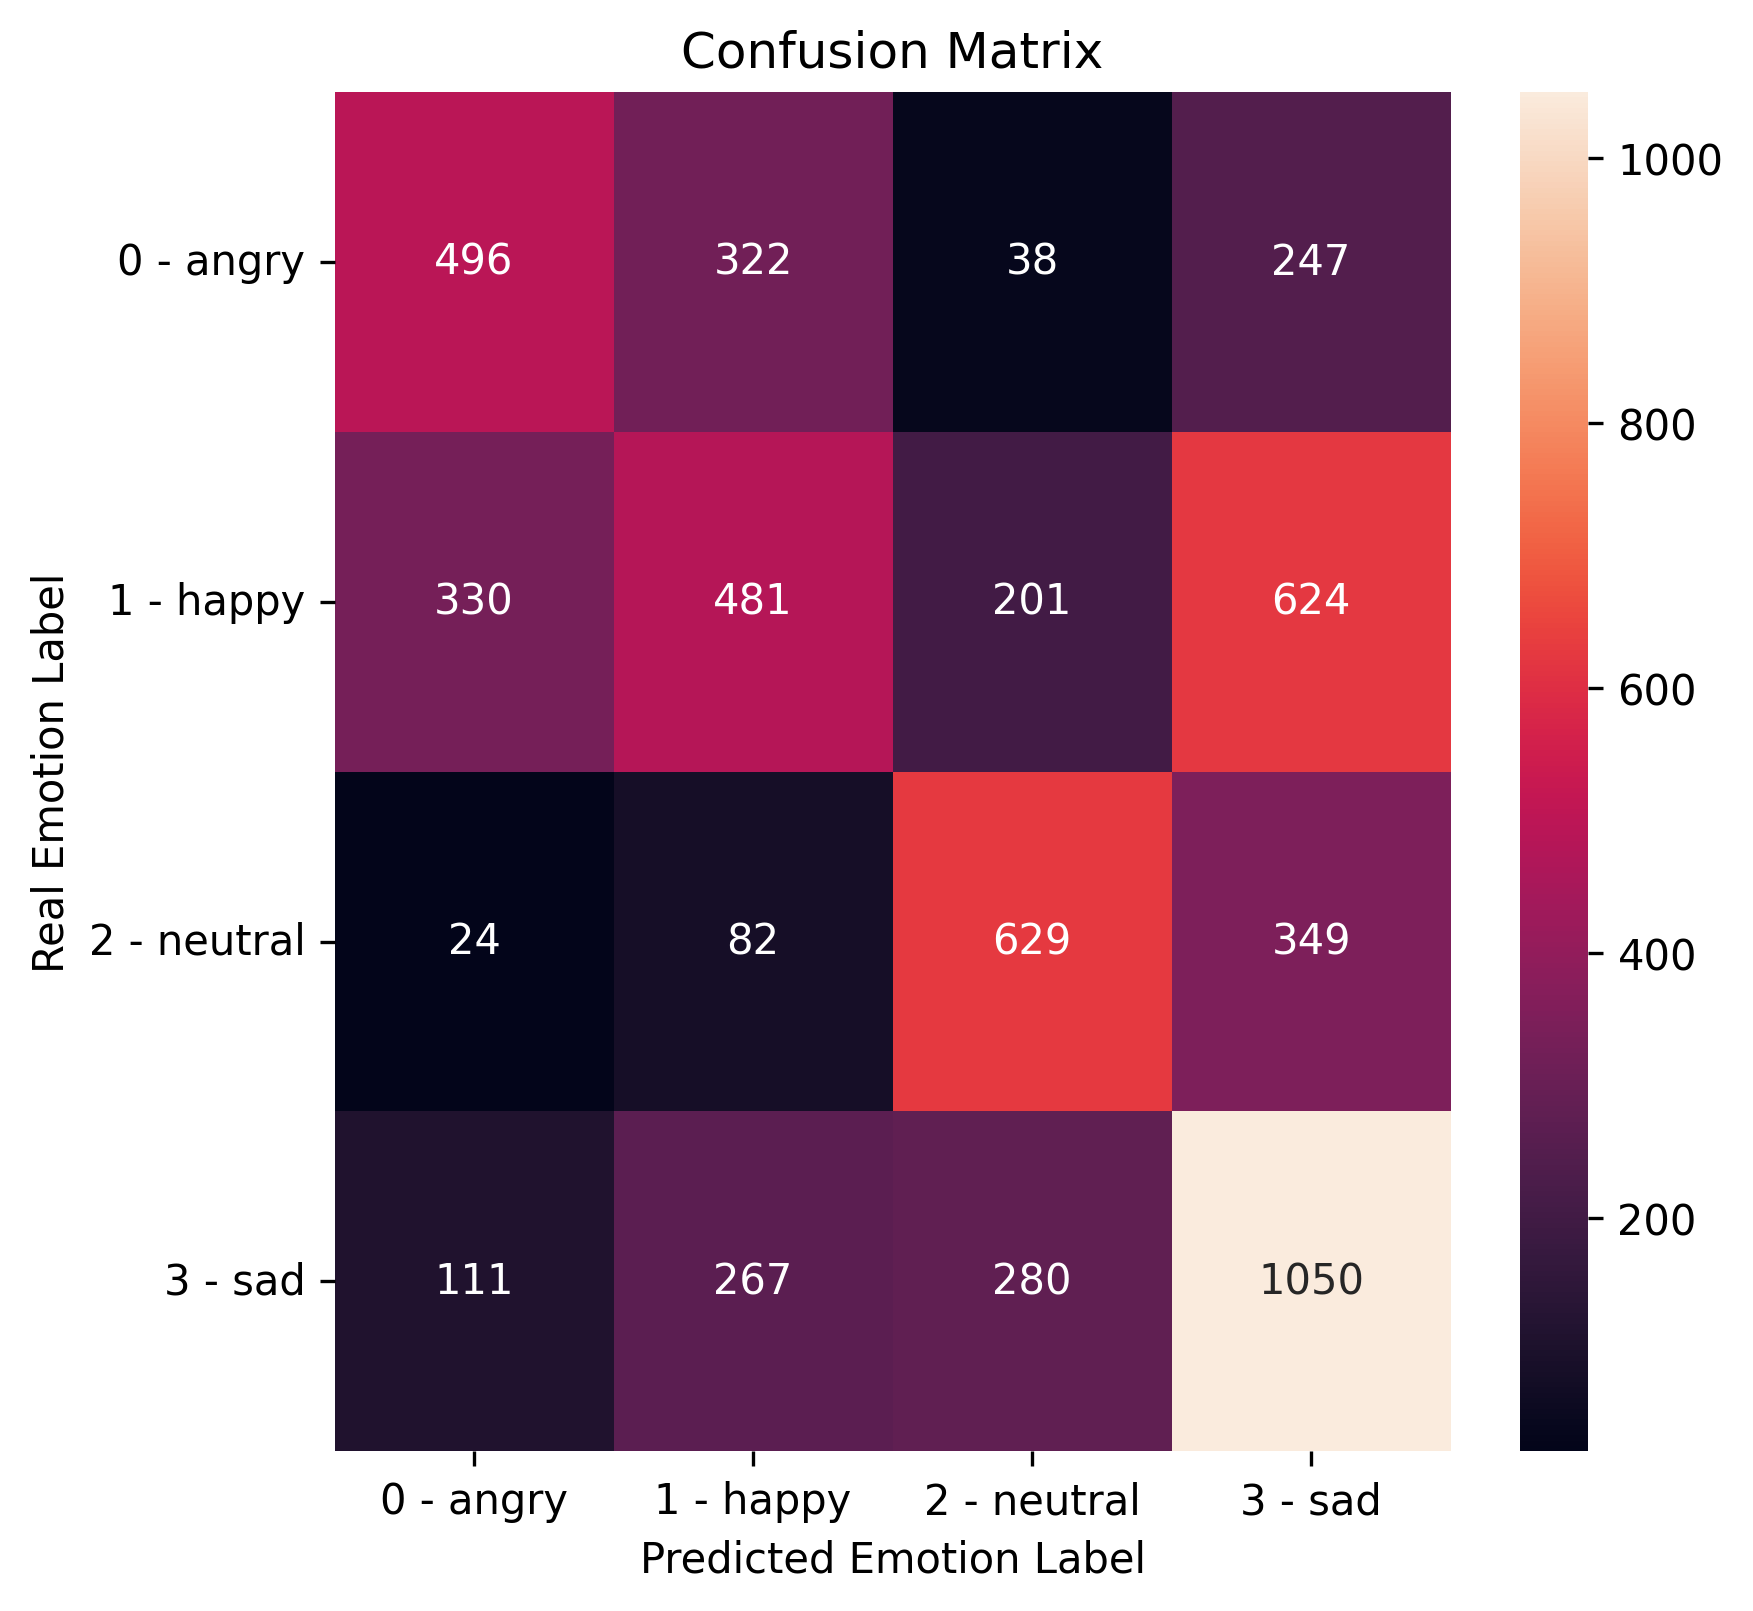

In [ ]:
get_metrics(all_y_labels, all_y_pred, training_times, prediction_times)

# Spectrograms

In [ ]:
%cd ./data/spectrograms
data_df = pd.DataFrame([(file, file[-5]) for file in glob("*.pickle")])

def data_loader(filename):
    features, labels = tf.py_function(
        get_y_and_label, [filename], [tf.float32, tf.int64])
    return tf.reshape(features, [1025, 188, 1]), tf.reshape(labels, [1])

print(len(data_df))
data_df.head()

/content/drive/MyDrive/Audio_Sentiment_Analysis/iemocap/data/spectrograms
5531


,0,1
0,Ses05F_impro06_F007-2-spec.pickle,i
1,Ses05F_impro06_F003-2-spec.pickle,i
2,Ses05F_impro06_F005-2-spec.pickle,i
3,Ses05F_impro06_F013-2-spec.pickle,i
4,Ses05F_impro06_F009-2-spec.pickle,i


## SOA Model 1

In [ ]:
def get_new_model(input_shape=(1025, 188, 1)):
    loss = SparseCategoricalCrossentropy()
    learning_rate = 1e-3
    optimizer = Adam(learning_rate=learning_rate)
    return build_model_1(input_shape, loss, optimizer)

get_new_model().summary(show_trainable=True)

Model: "sequential_1"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 conv2d_7 (Conv2D)           (None, 513, 94, 16)       800       Y          
                                                                            
 batch_normalization_7 (Batc  (None, 513, 94, 16)      64        Y          
 hNormalization)                                                            
                                                                            
 conv2d_8 (Conv2D)           (None, 257, 47, 32)       12832     Y          
                                                                            
 batch_normalization_8 (Batc  (None, 257, 47, 32)      128       Y          
 hNormalization)                                                            
                                                                            
 conv2d_9 (Conv2D)           (None, 129, 24, 32)      

In [ ]:
callback = EarlyStopping(monitor='loss', patience=5)
no_epochs = 60
batch_size = 64

verbosity = 1
num_folds = 5

all_y_labels, all_y_pred, training_times, prediction_times = categorical_cross_validation(
    get_new_model, data_df, callback, no_epochs, batch_size, verbosity, num_folds)

Training for fold 1 ...
Epoch 1/60
70/70 [==============================] - 208s 3s/step - loss: 1.4739 - accuracy: 0.3696 - val_loss: 1.4524 - val_accuracy: 0.2963
Epoch 2/60
70/70 [==============================] - 9s 134ms/step - loss: 1.2375 - accuracy: 0.4060 - val_loss: 1.7726 - val_accuracy: 0.2014
Epoch 3/60
70/70 [==============================] - 9s 132ms/step - loss: 1.2000 - accuracy: 0.4320 - val_loss: 1.6064 - val_accuracy: 0.3017
Epoch 4/60
70/70 [==============================] - 9s 133ms/step - loss: 1.1689 - accuracy: 0.4571 - val_loss: 1.3424 - val_accuracy: 0.3379
Epoch 5/60
69/70 [============================>.] - ETA: 0s - loss: 1.1627 - accuracy: 0.4461
on epoch  5  lr was adjusted from  0.0010000000474974513  to  0.0009000000427477062
70/70 [==============================] - 9s 134ms/step - loss: 1.1625 - accuracy: 0.4462 - val_loss: 1.3493 - val_accuracy: 0.3098
Epoch 6/60
70/70 [==============================] - 9s 135ms/step - loss: 1.1381 - accuracy: 0.4717 

Accuracy for fold 0: 50.77%
Accuracy for fold 1: 49.64%
Accuracy for fold 2: 50.99%
Accuracy for fold 3: 50.63%
Accuracy for fold 4: 48.55%

Metric             Value
-----------------  --------------
Accuracy           50.12+-0.91
F1 score macro     50.04
Precision          52.98
Recall             49.65
Matthews corrcoef  0.32
Training Time      3167.14+-69.69
Prediction Time    21.2+-0.11

              precision    recall  f1-score   support

           0       0.63      0.35      0.45      1103
           1       0.42      0.40      0.41      1636
           2       0.59      0.61      0.60      1084
           3       0.48      0.62      0.54      1708

    accuracy                           0.50      5531
   macro avg       0.53      0.50      0.50      5531
weighted avg       0.51      0.50      0.50      5531



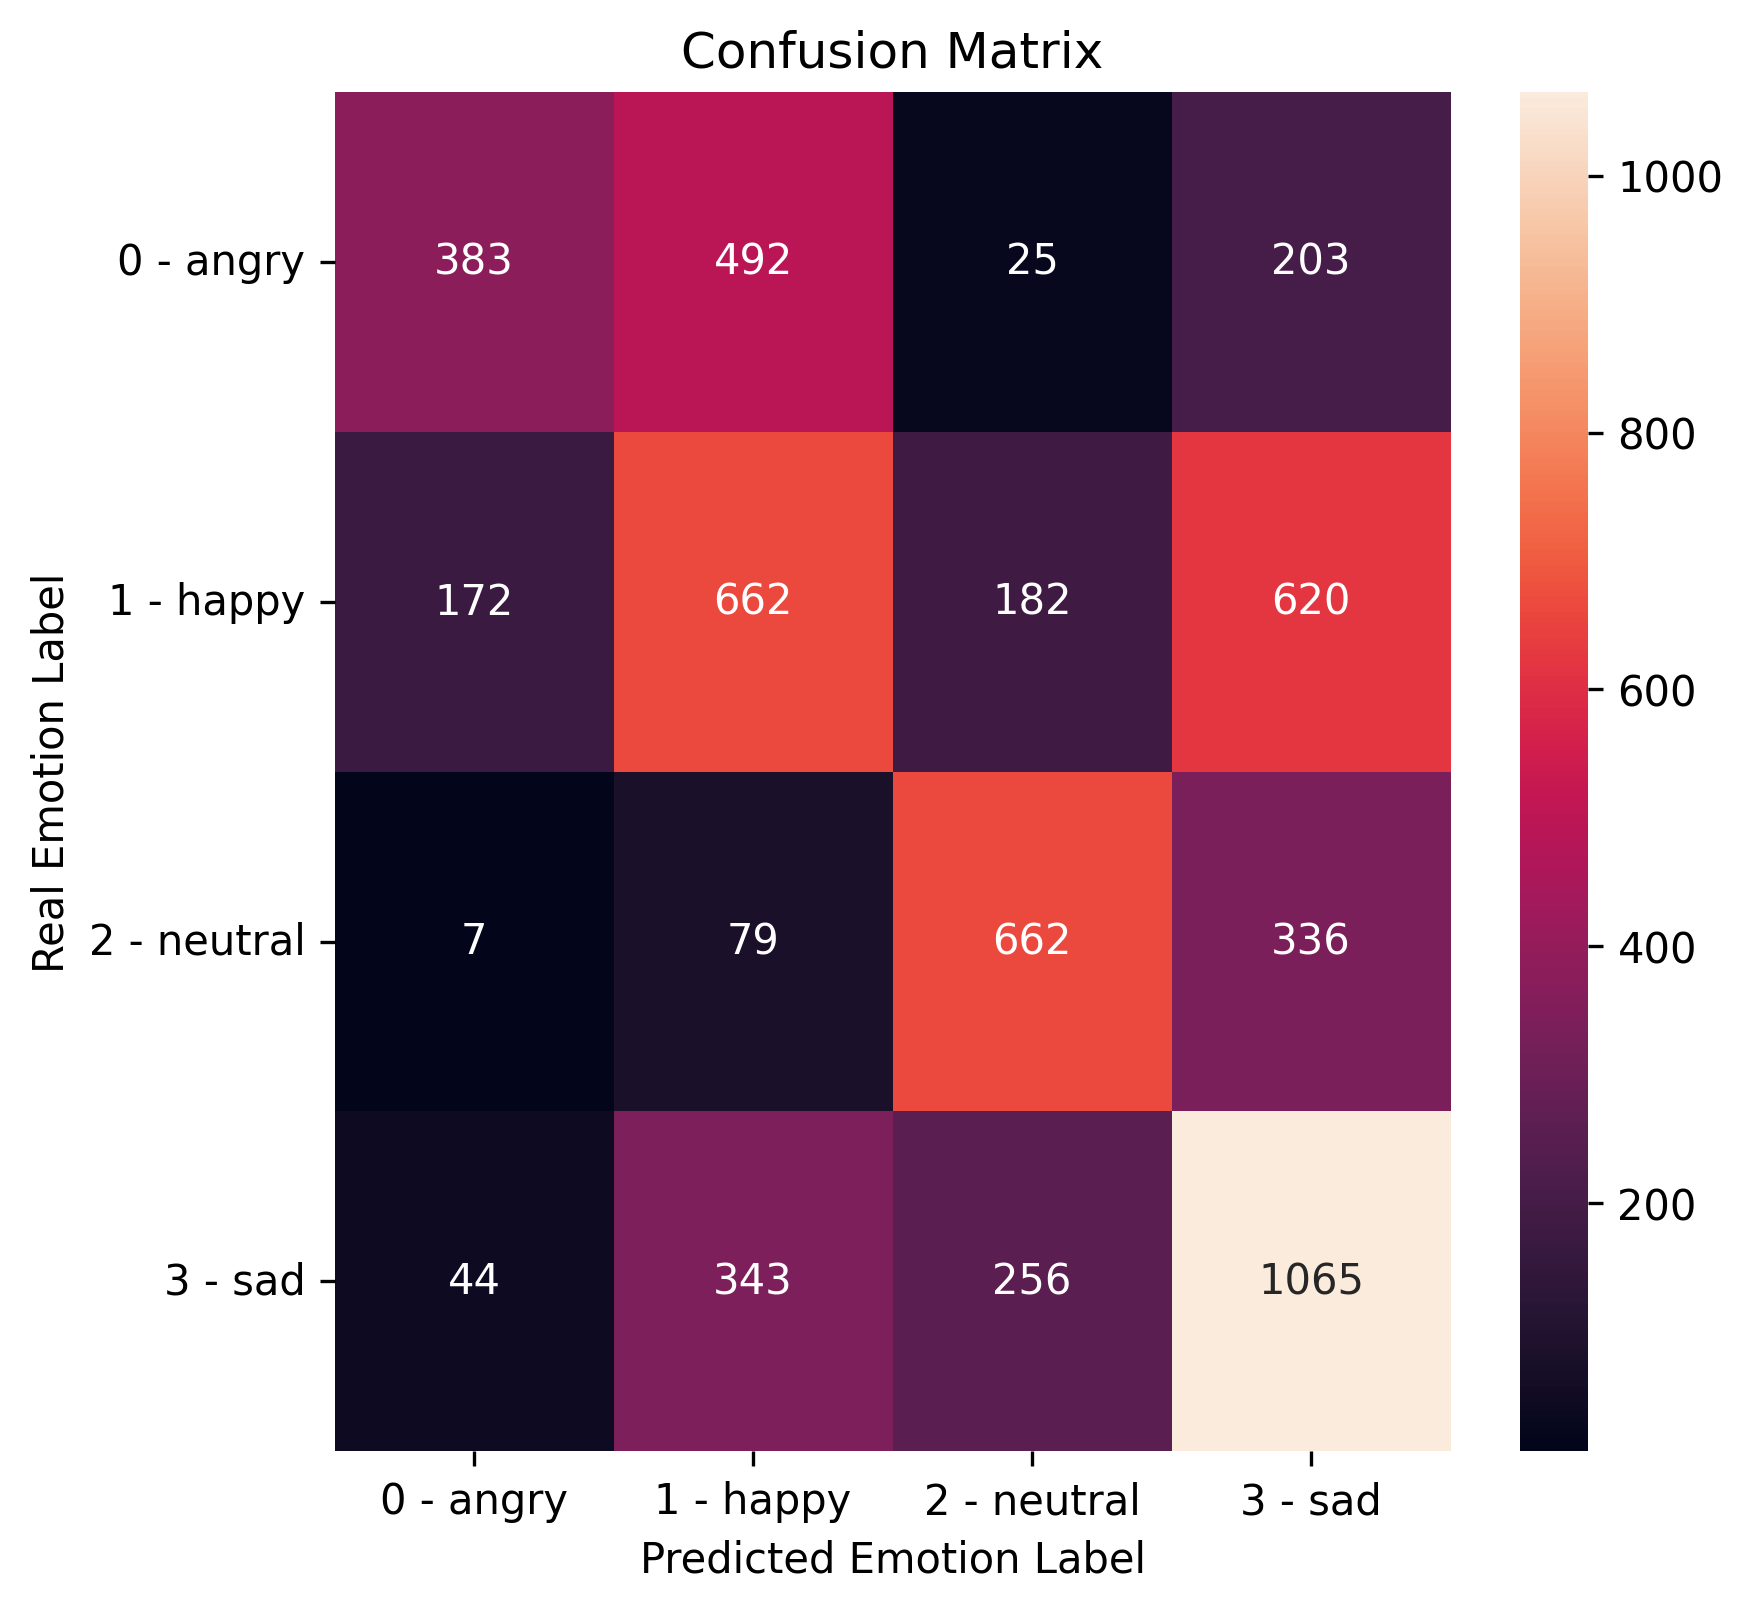

In [ ]:
get_metrics(all_y_labels, all_y_pred, training_times, prediction_times)

## SOA Model 2

In [ ]:
def get_new_model(input_shape=(1025, 188, 1)):
    loss = SparseCategoricalCrossentropy()
    learning_rate = 1e-3
    optimizer = Adam(learning_rate=learning_rate)
    return build_model_2(input_shape, loss, optimizer)

get_new_model().summary(show_trainable=True)

Model: "sequential_7"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 conv2d_49 (Conv2D)          (None, 1025, 177, 6)      78        Y          
                                                                            
 batch_normalization_49 (Bat  (None, 1025, 177, 6)     24        Y          
 chNormalization)                                                           
                                                                            
 max_pooling2d (MaxPooling2D  (None, 1025, 88, 6)      0         Y          
 )                                                                          
                                                                            
 conv2d_50 (Conv2D)          (None, 1025, 81, 10)      490       Y          
                                                                            
 max_pooling2d_1 (MaxPooling  (None, 1025, 40, 10)    

In [ ]:
callback = EarlyStopping(monitor='loss', patience=5)
no_epochs = 60
batch_size = 64

verbosity = 1
num_folds = 5

all_y_labels, all_y_pred, training_times, prediction_times = categorical_cross_validation(
    get_new_model, data_df, callback, no_epochs, batch_size, verbosity, num_folds)

Training for fold 1 ...
Epoch 1/60
70/70 [==============================] - 33s 380ms/step - loss: 1.3124 - accuracy: 0.3628 - val_loss: 1.3903 - val_accuracy: 0.3062
Epoch 2/60
70/70 [==============================] - 17s 248ms/step - loss: 1.1775 - accuracy: 0.4534 - val_loss: 1.3978 - val_accuracy: 0.3216
Epoch 3/60
70/70 [==============================] - 17s 245ms/step - loss: 1.1471 - accuracy: 0.4720 - val_loss: 1.2649 - val_accuracy: 0.3984
Epoch 4/60
70/70 [==============================] - 17s 242ms/step - loss: 1.1148 - accuracy: 0.4939 - val_loss: 1.2998 - val_accuracy: 0.3875
Epoch 5/60
70/70 [==============================] - ETA: 0s - loss: 1.0926 - accuracy: 0.5059
on epoch  5  lr was adjusted from  0.0010000000474974513  to  0.0009000000427477062
70/70 [==============================] - 17s 242ms/step - loss: 1.0926 - accuracy: 0.5059 - val_loss: 1.1355 - val_accuracy: 0.4860
Epoch 6/60
70/70 [==============================] - 17s 244ms/step - loss: 1.0753 - accuracy: 

Accuracy for fold 0: 43.99%
Accuracy for fold 1: 44.39%
Accuracy for fold 2: 46.75%
Accuracy for fold 3: 46.02%
Accuracy for fold 4: 48.92%

Metric             Value
-----------------  -------------
Accuracy           46.01+-1.77
F1 score macro     47.09
Precision          47.37
Recall             46.87
Matthews corrcoef  0.269
Training Time      5413.99+-9.95
Prediction Time    32.07+-0.57

              precision    recall  f1-score   support

           0       0.49      0.50      0.50      1103
           1       0.37      0.40      0.39      1636
           2       0.56      0.52      0.54      1084
           3       0.47      0.45      0.46      1708

    accuracy                           0.46      5531
   macro avg       0.47      0.47      0.47      5531
weighted avg       0.46      0.46      0.46      5531



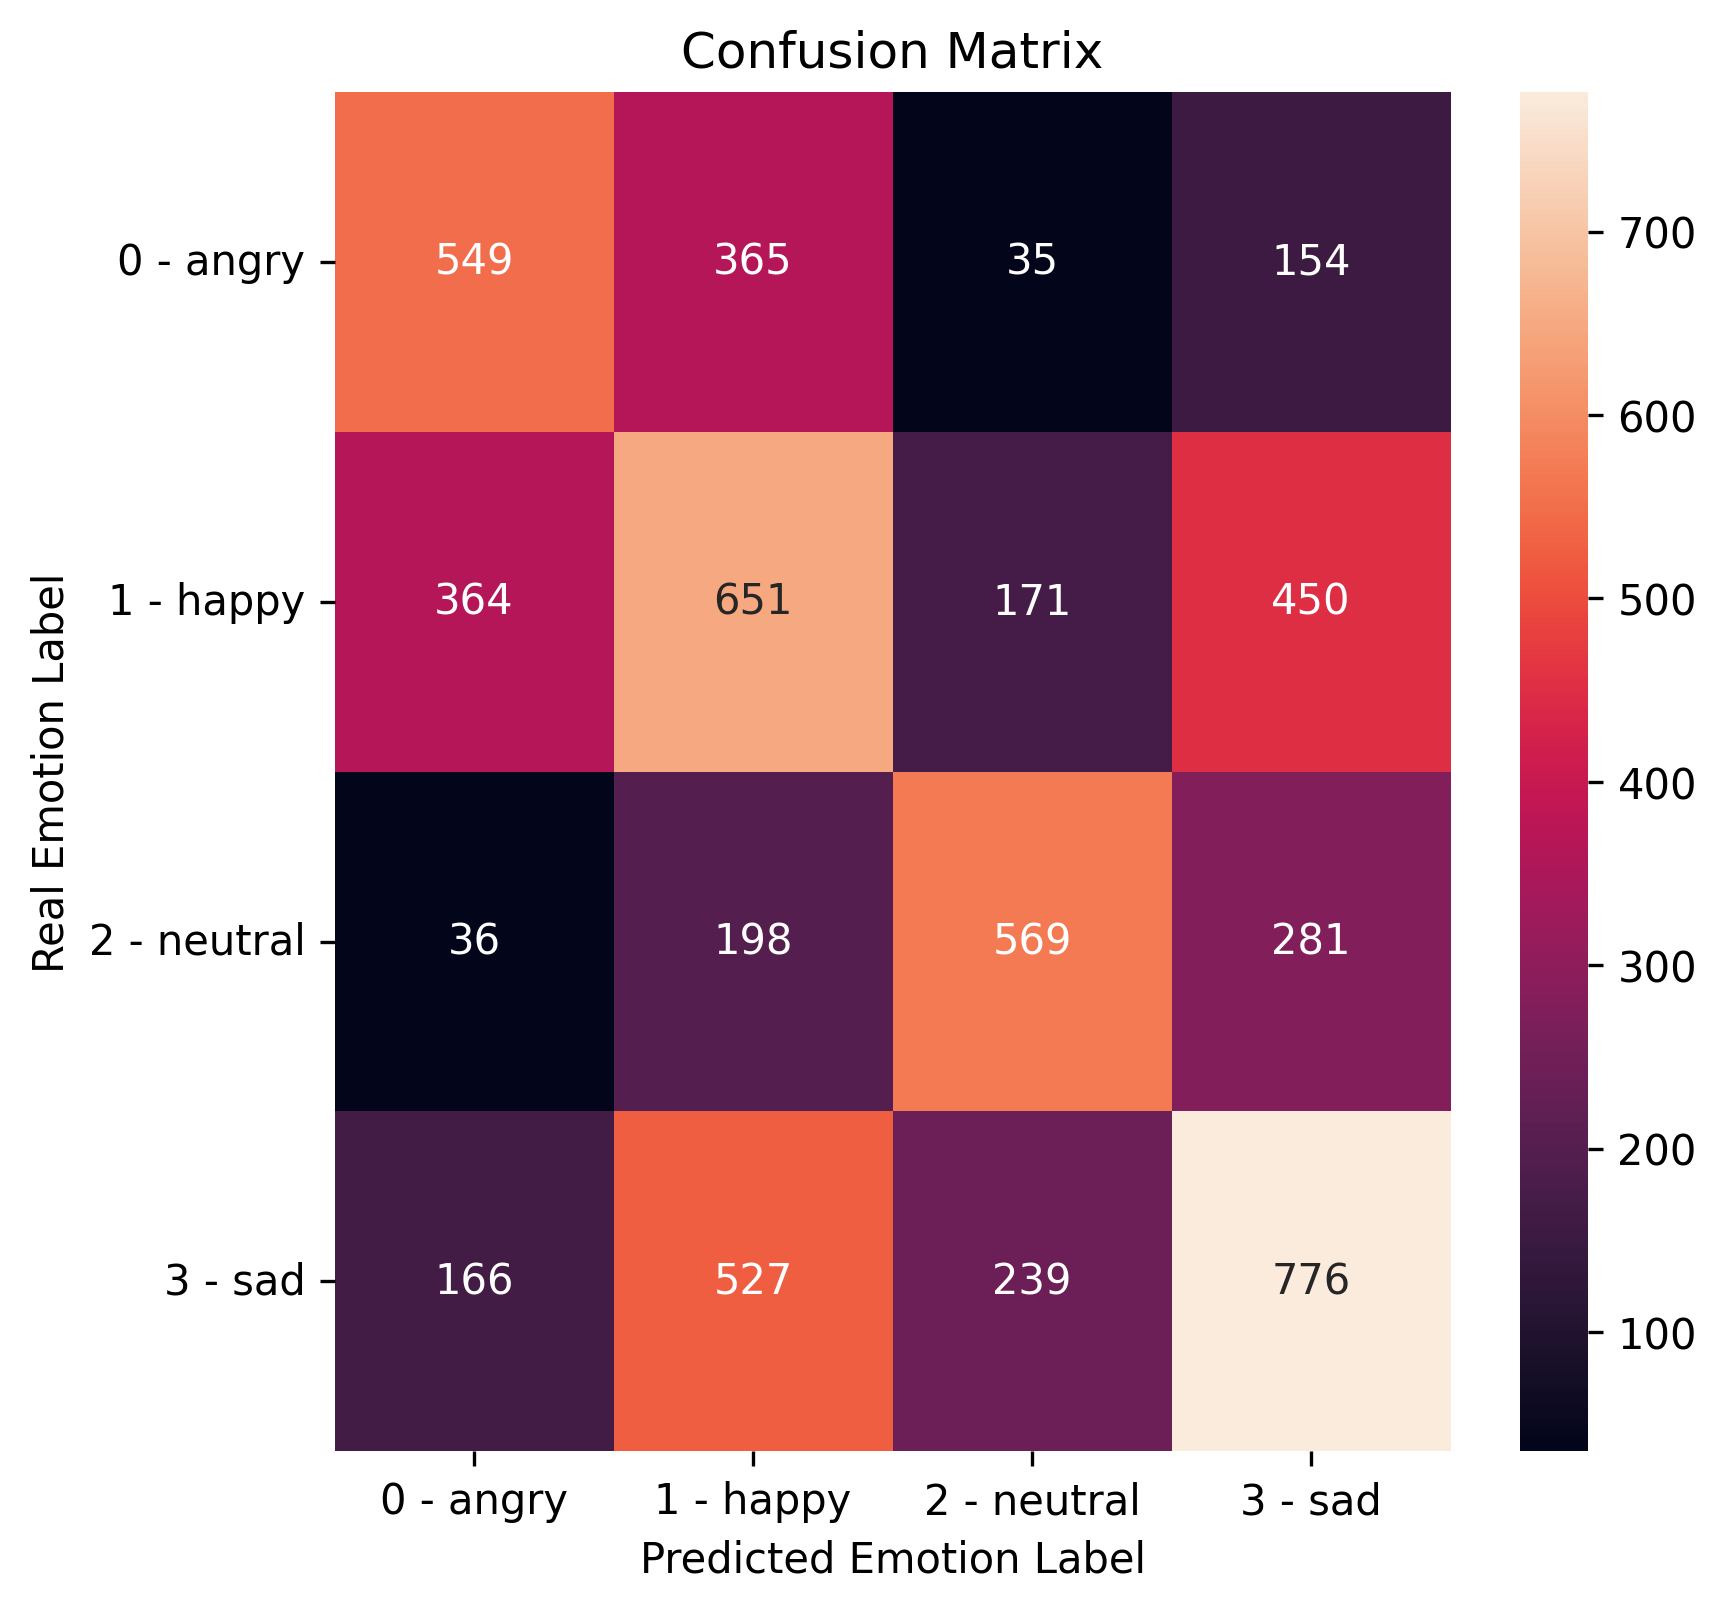

In [ ]:
get_metrics(all_y_labels, all_y_pred, training_times, prediction_times)

# MFCCs

In [ ]:
%cd ../mfccs
data_df = pd.DataFrame([(file, file[-5]) for file in glob("*.pickle")])

def data_loader(filename):
    features, labels = tf.py_function(
        get_y_and_label, [filename], [tf.float32, tf.int64])
    return tf.reshape(features, [40, 188, 1]), tf.reshape(labels, [1])

print(len(data_df))
data_df.head()

/content/drive/MyDrive/Audio_Sentiment_Analysis/iemocap/data/mfccs
5531


,0,1
0,Ses05F_impro06_F004-2-mfcc.pickle,i
1,Ses05F_impro06_F013-2-mfcc.pickle,i
2,Ses05F_impro06_F003-2-mfcc.pickle,i
3,Ses05F_impro06_F006-2-mfcc.pickle,i
4,Ses05F_impro06_F011-2-mfcc.pickle,i


## SOA Model 1

In [ ]:
def get_new_model(input_shape=(40, 188, 1)):
    loss = SparseCategoricalCrossentropy()
    learning_rate = 1e-3
    optimizer = Adam(learning_rate=learning_rate)
    return build_model_1(input_shape, loss, optimizer)

get_new_model().summary(show_trainable=True)

In [ ]:
callback = EarlyStopping(monitor='loss', patience=5)
no_epochs = 60
batch_size = 128

verbosity = 1
num_folds = 5

all_y_labels, all_y_pred, training_times, prediction_times = categorical_cross_validation(
    get_new_model, data_df, callback, no_epochs, batch_size, verbosity, num_folds)

Accuracy for fold 0: 46.52%
Accuracy for fold 1: 46.84%
Accuracy for fold 2: 45.21%
Accuracy for fold 3: 47.74%
Accuracy for fold 4: 47.2%

Metric             Value
-----------------  -------------
Accuracy           46.7+-0.85
F1 score macro     47.13
Precision          49.53
Recall             46.75
Matthews corrcoef  0.275
Training Time      303.49+-28.88
Prediction Time    5.18+-0.05

              precision    recall  f1-score   support

           0       0.61      0.37      0.46      1103
           1       0.40      0.35      0.38      1636
           2       0.55      0.58      0.56      1084
           3       0.43      0.57      0.49      1708

    accuracy                           0.47      5531
   macro avg       0.50      0.47      0.47      5531
weighted avg       0.48      0.47      0.46      5531



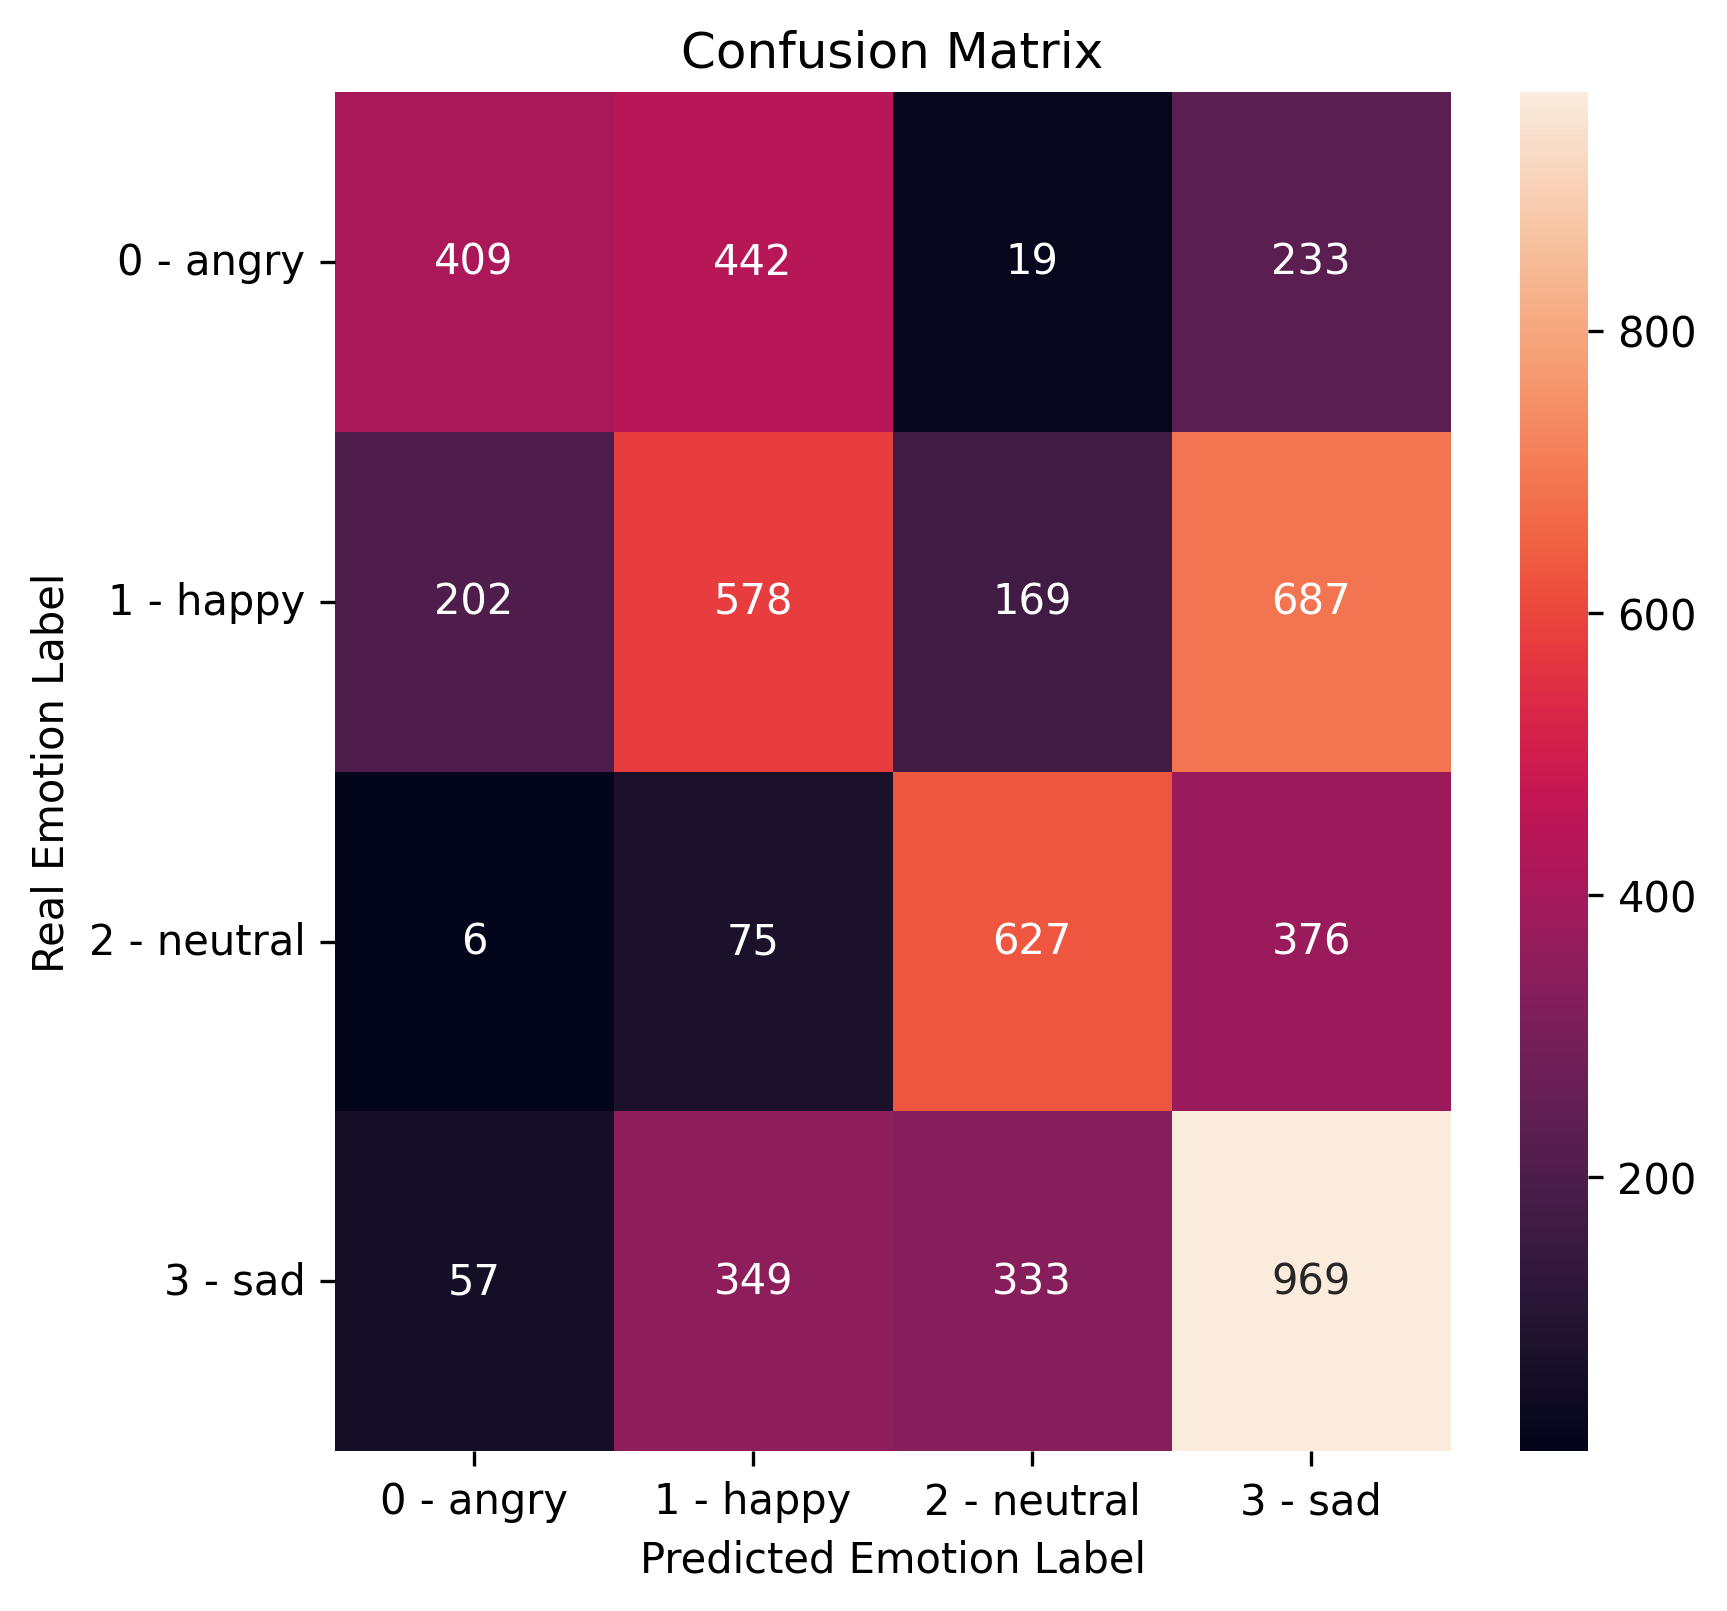

In [ ]:
get_metrics(all_y_labels, all_y_pred, training_times, prediction_times)

## SOA Model 2

In [ ]:
def get_new_model(input_shape=(40, 188, 1)):
    loss = SparseCategoricalCrossentropy()
    learning_rate = 1e-3
    optimizer = Adam(learning_rate=learning_rate)
    return build_model_2(input_shape, loss, optimizer)

get_new_model().summary(show_trainable=True)

In [ ]:
callback = EarlyStopping(monitor='loss', patience=5)
no_epochs = 60
batch_size = 128

verbosity = 1
num_folds = 5

all_y_labels, all_y_pred, training_times, prediction_times = categorical_cross_validation(
    get_new_model, data_df, callback, no_epochs, batch_size, verbosity, num_folds)

Accuracy for fold 0: 44.53%
Accuracy for fold 1: 44.48%
Accuracy for fold 2: 45.57%
Accuracy for fold 3: 45.57%
Accuracy for fold 4: 47.65%

Metric             Value
-----------------  ------------
Accuracy           45.56+-1.15
F1 score macro     46.26
Precision          46.29
Recall             46.25
Matthews corrcoef  0.263
Training Time      298.06+-1.31
Prediction Time    12.29+-0.37

              precision    recall  f1-score   support

           0       0.49      0.50      0.49      1103
           1       0.39      0.38      0.39      1636
           2       0.51      0.50      0.50      1084
           3       0.46      0.47      0.47      1708

    accuracy                           0.46      5531
   macro avg       0.46      0.46      0.46      5531
weighted avg       0.46      0.46      0.46      5531



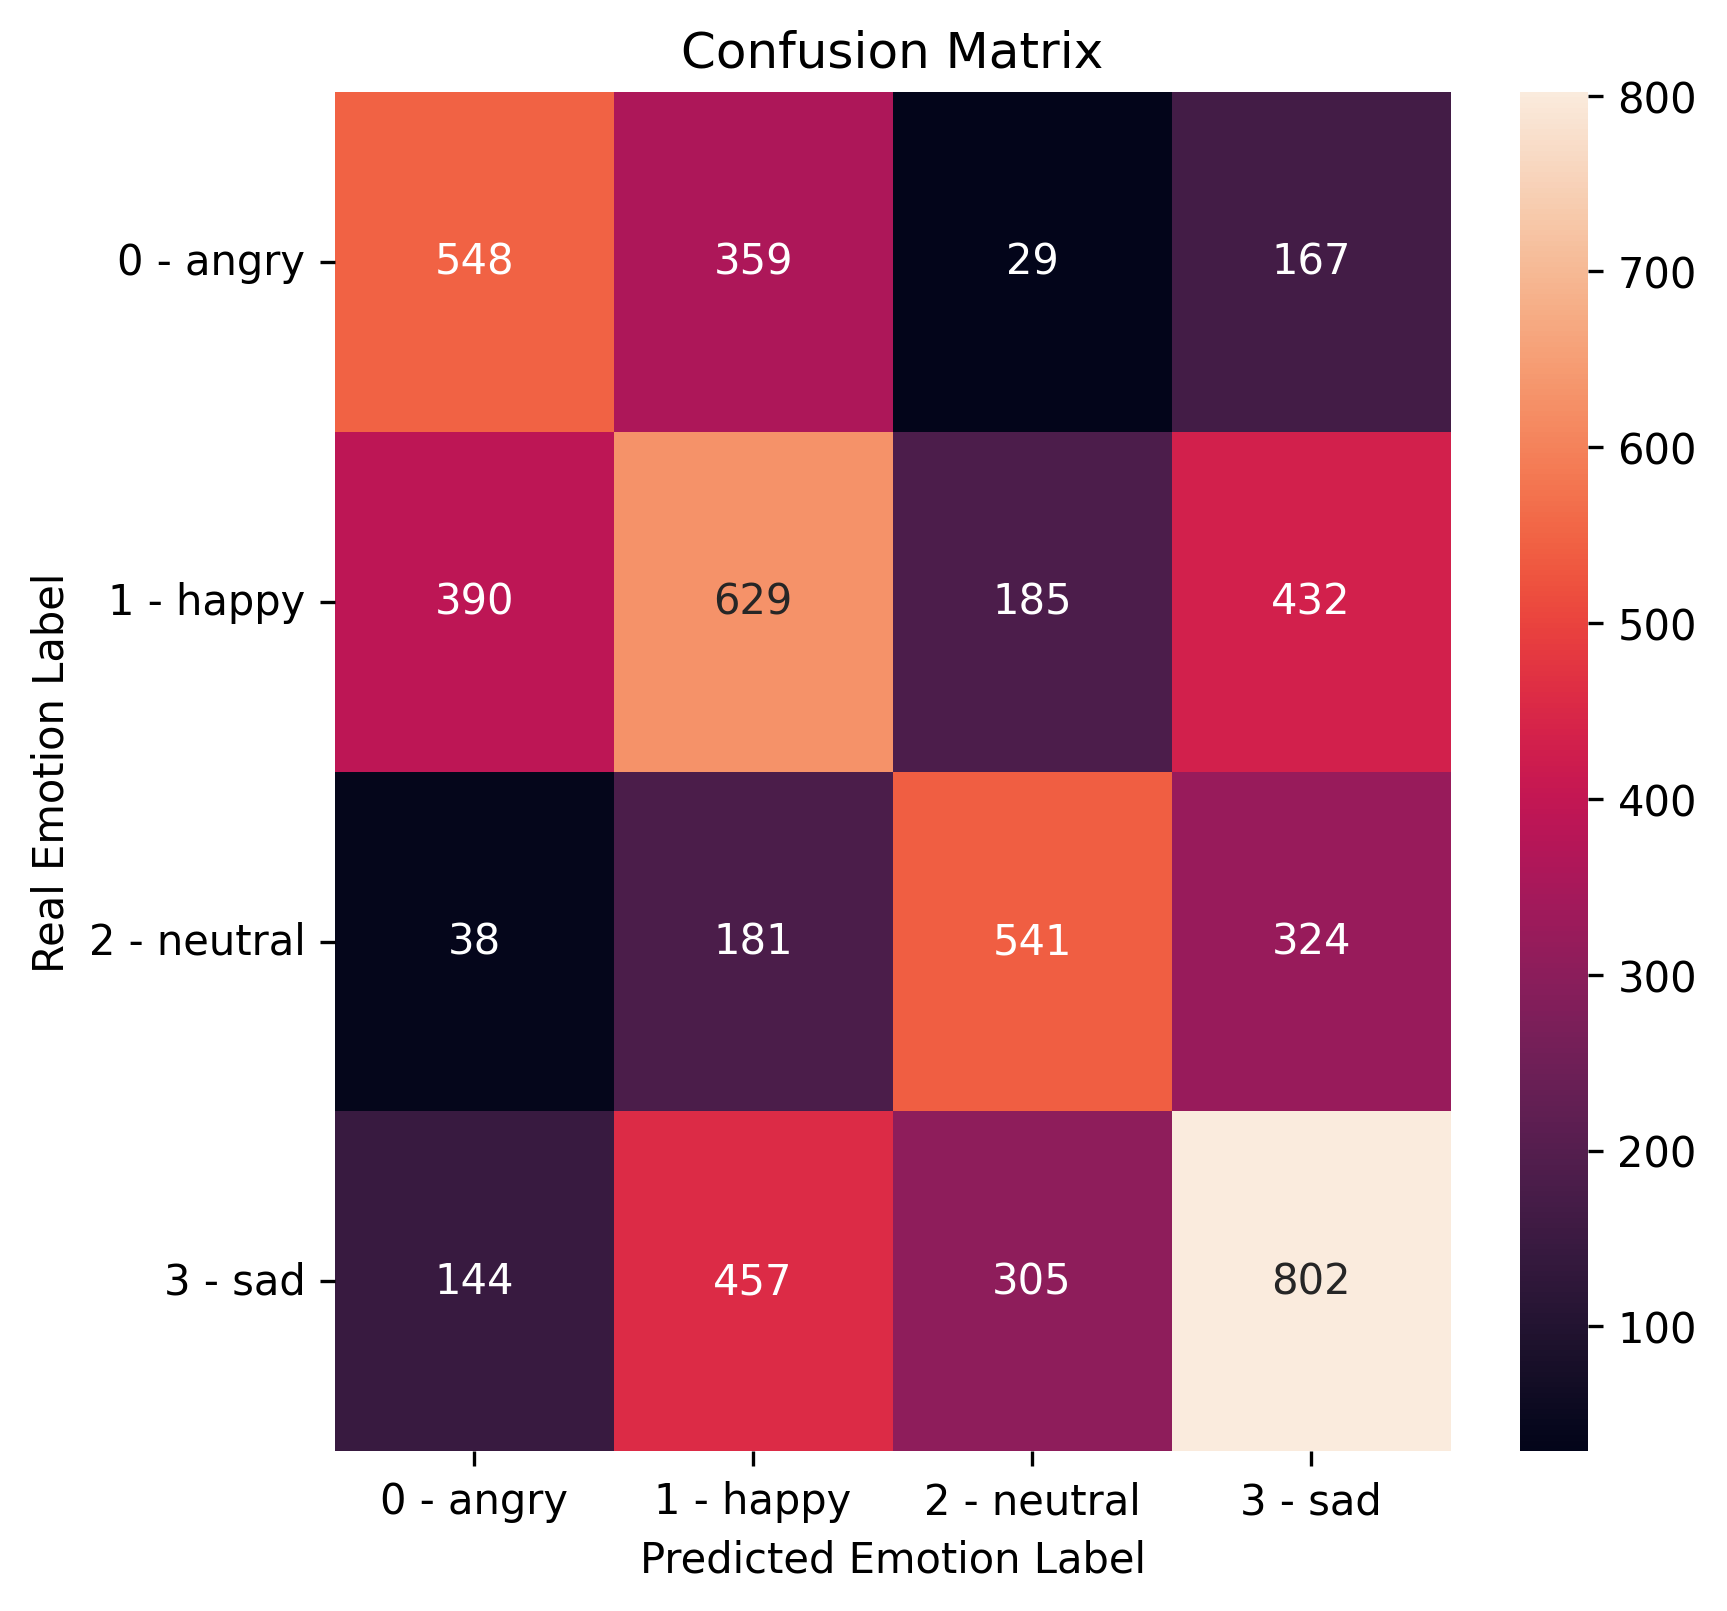

In [ ]:
get_metrics(all_y_labels, all_y_pred, training_times, prediction_times)